In [1]:
from hblteuk import RadialTeukolsky, HyperboloidalTeukolsky
from swsh import SpinWeightedSpheroidalHarmonic as SWSH
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
import os
os.environ['PATH'] += ':/Library/TeX/texbin:/opt/X11/bin' 
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 24})
import numpy as np
import math

In [2]:
from spheroidal import SpinWeightedSpheroidalHarmonic

In [278]:
s = -2
a = 0.9
l = 5
m = 5
omega = 10.234831

In [279]:
def sigma_temp(a, r):
    kappa = np.sqrt(1-a**2)
    return 2.*kappa/(r - (1. - kappa))

def r_temp(a, sig):
    kappa = np.sqrt(1-a**2)
    return (2*kappa + (1 - kappa)*sig )/sig

In [280]:
hbl = HyperboloidalTeukolsky(a, s, l, m, omega)
hbl.solve(subdomains = 50, chebyshev_samples = 32, cutoff=[hbl.sigma_of_r(6.), hbl.sigma_of_r(6.)], use_ts_transform=False)

In [287]:
%timeit hbl.solve(subdomains = 50, chebyshev_samples = 32, cutoff=[hbl.sigma_of_r(6.), hbl.sigma_of_r(6.)], use_ts_transform=False)

42.1 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [289]:
import numpy.polynomial.chebyshev as ch

In [291]:
ch.chebpts2(16)

array([-1.        , -0.9781476 , -0.91354546, -0.80901699, -0.66913061,
       -0.5       , -0.30901699, -0.10452846,  0.10452846,  0.30901699,
        0.5       ,  0.66913061,  0.80901699,  0.91354546,  0.9781476 ,
        1.        ])

In [243]:
# %timeit hbl.solve(subdomains = 200, chebyshev_samples=32, cutoff=[hbl.sigma_of_r(40.), hbl.sigma_of_r(4.)], use_ts_transform=False)

In [244]:
# %timeit hbl.solve(subdomains = 120, cutoff=[hbl.sigma_of_r(40.), hbl.sigma_of_r(4.)], use_ts_transform=False)

In [245]:
Psihbl = hbl()

In [246]:
dPsihblIn = Psihbl['In'].mch.deriv(6)
dPsihblUp = Psihbl['Up'].mch.deriv(6)

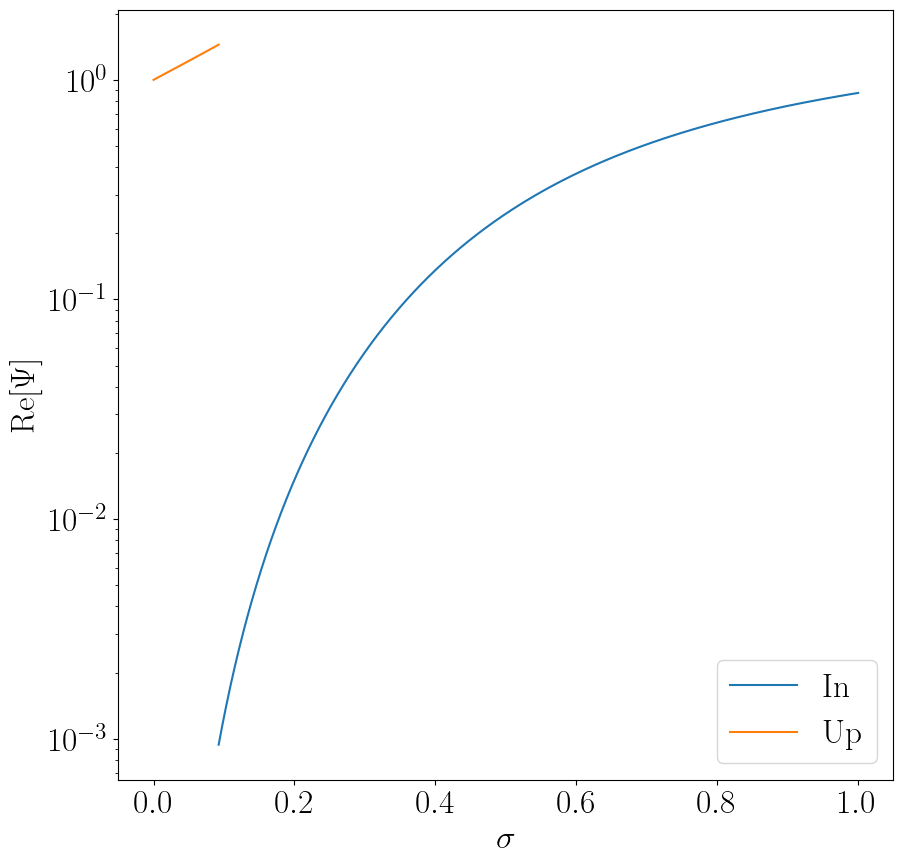

In [248]:
plt.figure(figsize=(10,10))
plt.plot(*np.abs(np.abs(Psihbl['In'].linspace(5000))), label='In')
plt.plot(*np.abs(np.abs(Psihbl['Up'].linspace(5000))), label='Up')
plt.yscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'Re[$\Psi$]')
plt.legend()
plt.show()

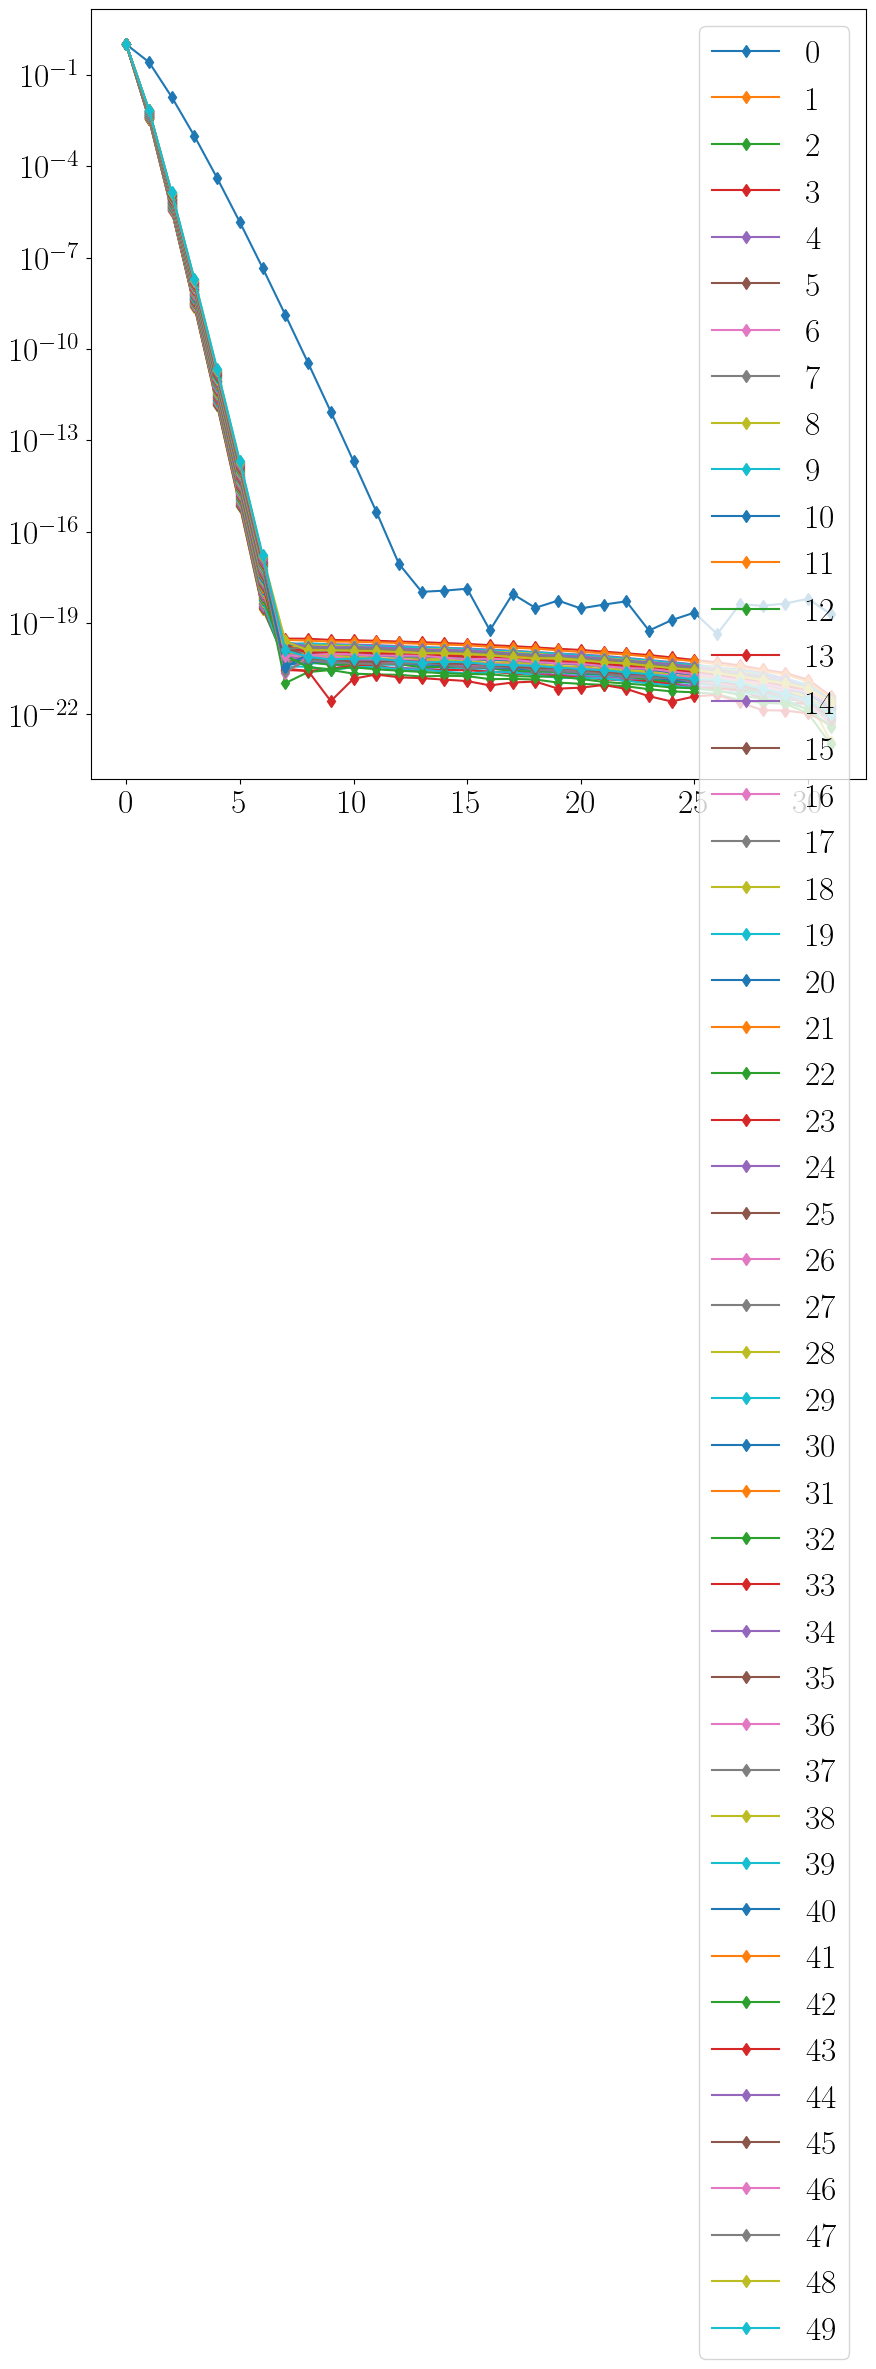

In [249]:
plt.figure(figsize=(10, 10))
for i in range(hbl.mch['Up'].coeffs.shape[0]):
    # plt.plot(np.abs(hbl.mch['In'].coeffs[i])/np.abs(hbl.mch['In'].coeffs[i][0]), 'o-')
    plt.plot(np.abs(hbl.mch['Up'].coeffs[i])/np.abs(hbl.mch['Up'].coeffs[i][0]), 'd-', label = i)
plt.yscale('log')
plt.legend()
plt.show()

In [5]:
import kerrgeopy as kg
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def generate_frequencies(a, p, e, x, constants):
    upR = kg.frequencies.r_frequency(a, p, e, x, constants)
    upTh = kg.frequencies.theta_frequency(a, p, e, x, constants)
    upPh = kg.frequencies.phi_frequency(a, p, e, x, constants, upR, upTh)
    gamma = kg.frequencies.gamma(a, p, e, x, constants, upR, upTh)
    return np.array((gamma, upR, upTh, upPh))

In [7]:
class MiniGeo:
    def __init__(self, a, p, e, x):
        self.a = a
        self.p = p
        self.e = e
        self.x = x
        self.constants = kg.constants.constants_of_motion(a, p, e, x)
        self.En = self.constants[0]
        self.Lz = self.constants[1]
        self.Qc = self.constants[2]
        self.radial_roots = kg.constants.stable_radial_roots(a, p, e, x, self.constants)
        self.mino_frequencies = generate_frequencies(a, p, e, x, self.constants)
        self.frequencies = self.mino_frequencies[1:]/self.mino_frequencies[0]
        self.radial_solutions = kg.stable.radial_solutions(a, self.constants, self.radial_roots)

    def r(self, qr):
        return self.radial_solutions[0](qr)

    def tr(self, qr):
        return self.radial_solutions[1](qr)

    def phir(self, qr):
        return self.radial_solutions[2](qr)

    def ur(self, qr):
        r = self.r(qr)
        Delta = r**2 - 2.*r + self.a**2
        return np.sign(np.sin(qr))*np.sqrt(np.abs((self.En*(r**2 + self.a**2) - self.a*self.Lz)**2 - Delta*(r**2 + (self.Lz - self.a*self.En)**2 + self.Qc)))
    
    def r_velocity(self, qr):
        return self.ur(qr)/(self.r(qr)**2)

    def mode_frequency(self, m, k, n):
        return np.dot(self.frequencies, (n, k, m))

In [8]:
orbit = MiniGeo(0.9, 4., 0.3, 1)

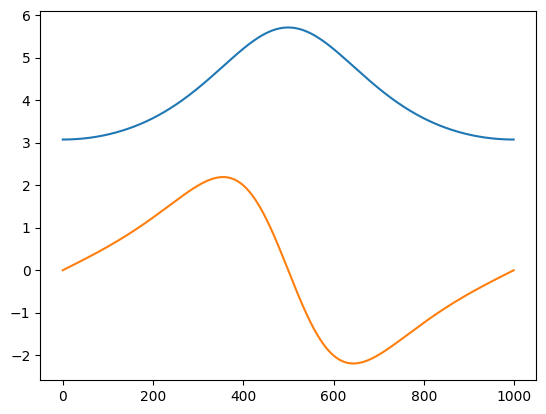

In [9]:
plt.plot(orbit.r(np.linspace(0, 2*np.pi, 1000)))
plt.plot(orbit.ur(np.linspace(0, 2*np.pi, 1000)))

In [30]:
def scalar_source_equatorial(l, m, n, geo, nsamples = 2**9):
    omega = geo.mode_frequency(m, 0, n)
    a = geo.a
    Sslm = SpinWeightedSpheroidalHarmonic(0, l, m, a*omega)
    th = np.array([0.5*np.pi])
    Seq = Sslm(th, 0.)[0]

    hbl = HyperboloidalTeukolsky(a, 0, l, m, omega)
    rmin = geo.radial_roots[1]
    rmax = geo.radial_roots[0]
    smin = hbl.sigma_of_r(rmax)
    smax = hbl.sigma_of_r(rmin)
    # print(f"smin = {smin}, smax = {smax}")
    hbl.solve(cutoff=[smin, smax])

    Psihbl = hbl()
    phase_points = np.linspace(0, 2.*np.pi, nsamples + 1)[:-1]
    radial_points = geo.r(phase_points)
    sigma_points = hbl.sigma_of_r(radial_points)
    PsiUp = Psihbl["Up"](sigma_points)
    PsiIn = Psihbl["In"](sigma_points)
    Sigma = radial_points**2 
    Gamma = geo.mino_frequencies[0]
    Phase = n*phase_points + omega*geo.tr(phase_points) - m*geo.phir(phase_points)
    # Phase = omega*geo.tr((1+1e-14)*phase_points) - m*geo.phir(phase_points)

    wronskian = Psihbl["In"](smax)*Psihbl["Up"](smax, deriv = 1) - Psihbl["Up"](smax)*Psihbl["In"](smax, deriv = 1)
    const_wronskian = hbl.Zsigma(smax)**2*(rmin**2 - 2.*rmin + a**2)*hbl.dsigma_dr(rmin)*wronskian

    sourceFactor = -4*np.pi/Gamma*Seq*np.exp(1j*Phase)*Sigma*hbl.Zsigma(sigma_points)/const_wronskian

    return [sourceFactor*PsiUp, sourceFactor*PsiIn]


In [31]:
geo = MiniGeo(0.9, 10., 0.4, 1.)
np.mean(scalar_source_equatorial(2, 2, 4, geo, nsamples=2**8), axis = 1)

array([-0.00031428+0.00022399j, -0.01096773+0.00601952j])

In [32]:
def gravitational_source_equatorial(l, m, n, geo, nsamples = 2**9):
    omega = geo.mode_frequency(m, 0, n)
    a = geo.a
    En, Lz, _ = geo.constants
    Sslm = SpinWeightedSpheroidalHarmonic(-2, l, m, a*omega)
    th = 0.5*np.pi
    uth = 0.
    sth = np.sin(th)
    cth = np.cos(th)

    # Seq = Sslm(np.array([th]))[0]
    # dSeq = Sslm.deriv(np.array([th]))[0]
    # d2Seq = Sslm.deriv2(np.array([th]))[0]
    Seq = Sslm(th, 0.)
    dSeq = Sslm.deriv(th, 0.)
    d2Seq = Sslm.deriv2(th, 0.)

    L1 = -m/sth + a*omega*sth + cth/sth
    L2 = -m/sth + a*omega*sth + 2.*cth/sth
    L2S = dSeq + L2*Seq
    L2p = m*cth/sth**2 + a*omega*cth - 2./sth**2
    L1Sp = d2Seq + L1*dSeq
    L1L2S = L1Sp + L2p*Seq + L2*dSeq + L1*L2*Seq

    hbl = HyperboloidalTeukolsky(a, -2, l, m, omega)
    rmin = geo.radial_roots[1]
    rmax = geo.radial_roots[0]
    smin = hbl.sigma_of_r(rmax)
    smax = hbl.sigma_of_r(rmin)
    hbl.solve(cutoff=[smin, smax], use_ts_transform=False)
    
    Psihbl = hbl()
    qr = np.linspace(0, 2.*np.pi, nsamples + 1)[:-1]
    rp = geo.r(qr)
    urp = geo.ur(qr)

    # plt.plot(rp)
    # plt.plot(urp)
    # plt.show()

    sp = hbl.sigma_of_r(rp)
    PsiUp = Psihbl["Up"](sp)
    PsiIn = Psihbl["In"](sp)
    dPsiUp = Psihbl["Up"](sp, deriv=1)
    dPsiIn = Psihbl["In"](sp, deriv=1)
    d2PsiUp = Psihbl["Up"](sp, deriv=2)
    d2PsiIn = Psihbl["In"](sp, deriv=2)

    Delta = rp**2 - 2.*rp + a**2
    DeltaSqrt2 = np.sqrt(2)*Delta
    Kt = (rp**2 + a**2)*omega - m*a
    rho = -1./(rp - 1j*a*cth)
    rhobar = -1./(rp + 1j*a*cth)
    Sigma = 1/rho/rhobar

    Ann0 = -rho**(-2)*rhobar**(-1)*DeltaSqrt2**(-2)*(rho**(-1)*L1L2S + 3j*a*sth*L1*Seq + 3j*a*cth*Seq + 2j*a*sth*dSeq - 1j*a*sth*L2*Seq)
    Anmbar0 = rho**(-3)*DeltaSqrt2**(-1)*((rho + rhobar - 1j*Kt/Delta)*L2S + (rho - rhobar)*a*sth*Kt/Delta*Seq)
    Anmbar1 = -rho**(-3)*DeltaSqrt2**(-1)*( L2S + 1j*(rho - rhobar)*a*sth*Seq)
    Ambarmbar0 = rho**(-3)*rhobar*DeltaSqrt2**(-2)*(0.5*Kt**2 + 1j*Kt*(1. - rp + Delta*rho) + 1j*rp*omega*Delta)*Seq
    Ambarmbar1 = -0.5*(rho)**(-3)*rhobar*(1j*Kt/Delta - rho)*Seq
    Ambarmbar2 = -0.25*(rho)**(-3)*rhobar*Seq

    # print(np.array([Ann0, Anmbar0, Anmbar1, Ambarmbar0, Ambarmbar1, Ambarmbar2])[:, 0])

    Cr = (En*(rp**2 + a**2) - a*Lz + urp)/(2*Sigma)
    Cth = rho*(1j*sth*(a*En - Lz/sth**2) + uth)/np.sqrt(2)

    # print(np.array([Cr, Cth])[:,0])

    Cnn = Cr*Cr
    Cnmbar = Cr*Cth
    Cmbarmbar = Cth*Cth

    rphase = omega*geo.tr(qr) - m*geo.phir(qr) + n*qr

    A0 = Ann0*Cnn + Anmbar0*Cnmbar + Ambarmbar0*Cmbarmbar
    A1 = -(Anmbar1*Cnmbar + Ambarmbar1*Cmbarmbar)
    A2 = Ambarmbar2*Cmbarmbar

    Zs = hbl.Zsigma(sp)
    dZs = hbl.Zsigma_deriv(sp)
    d2Zs = hbl.Zsigma_deriv2(sp)

    gs = hbl.dsigma_dr_of_sigma(sp)
    dgs = hbl.dsigma_dr_of_sigma_deriv(sp)

    B0 = A0*Zs + A1*gs*dZs + A2*gs*(dgs*dZs + gs*d2Zs)
    B1 = A1*gs*Zs + A2*gs*(dgs*Zs + 2.*gs*dZs)
    B2 = A2*gs*gs*Zs

    base = np.array([(B0*PsiUp + B1*dPsiUp + B2*d2PsiUp), (B0*PsiIn + B1*dPsiIn + B2*d2PsiIn)])

    # print(np.array([Zs*PsiUp, gs*dZs*PsiUp + gs*Zs*dPsiUp, gs*(dgs*Zs + 2.*gs*dZs)*PsiUp + gs*(dgs*dZs + gs*d2Zs)*dPsiUp + gs*gs*Zs*d2PsiUp])[:,1])
    # print(np.array([Zs*PsiIn, gs*dZs*PsiIn + gs*Zs*dPsiIn, gs*(dgs*Zs + 2.*gs*dZs)*PsiIn + gs*(dgs*dZs + gs*d2Zs)*dPsiIn + gs*gs*Zs*d2PsiIn])[:,1])

    Gamma = geo.mino_frequencies[0]
    wronskian = Psihbl["In"](smax)*Psihbl["Up"](smax, deriv = 1) - Psihbl["Up"](smax)*Psihbl["In"](smax, deriv = 1)
    const_wronskian = hbl.Zsigma(smax)**2*(rmin**2 - 2.*rmin + a**2)**(-1)*hbl.dsigma_dr(rmin)*wronskian

    # print(base, const_wronskian, Gamma)

    return -8.*np.pi*base*np.exp(1j*rphase)/const_wronskian/Gamma

In [33]:
a = 0.9
geo = MiniGeo(a, 10., 0.2, 1.)
np.mean(gravitational_source_equatorial(2, 2, 0, geo, nsamples=2**8), axis = 1)

array([-0.00090331-0.00026534j, -0.00074325+0.00019606j])

In [34]:
from pybhpt.teuk import TeukolskyMode
from pybhpt.geo import KerrGeodesic

In [35]:
orb = KerrGeodesic(a, 10., 0.2, 1., nsamples=2**9)
teuk = TeukolskyMode(-2, 2, 2, 0, 0, orb)
teuk.solve(orb)
# print([teuk.amplitude('In'), teuk.amplitude('Up')])
1-np.array([teuk.amplitude('In'), teuk.amplitude('Up')])/np.mean(gravitational_source_equatorial(2, 2, 0, geo, nsamples=2**10), axis = 1)

array([2.03789208e-11-9.35123657e-12j, 5.95451466e-11+1.95983517e-11j])

In [36]:
from hblteuk import RadialTeukolsky, HyperboloidalTeukolsky
from swsh import SpinWeightedSpheroidalHarmonic
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
import os
os.environ['PATH'] += ':/Library/TeX/texbin:/opt/X11/bin' 
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 24})
import numpy as np
import math
from pybhpt.radial import RadialTeukolsky

In [37]:
def sigma_temp(a, r):
    kappa = np.sqrt(1-a**2)
    return 2.*kappa/(r - (1. - kappa))

def r_temp(a, sig):
    kappa = np.sqrt(1-a**2)
    return (2*kappa + (1 - kappa)*sig )/sig

In [38]:
s = -2
a = 0.9
l = 2
m = 2
omega = teuk.frequency
r = np.array([4., 40.])
Rt = RadialTeukolsky(s, l, m, a, omega, r)
Rt.solve()

In [39]:
hbl = HyperboloidalTeukolsky(a, s, l, m, omega)
hbl.solve(cutoff=[hbl.sigma_of_r(r[1]), hbl.sigma_of_r(r[0])], use_ts_transform=False)

In [40]:
hbl.domains['In']

array([1.        , 0.75      , 0.66940478, 0.59747034, 0.533266  ,
       0.47596108, 0.42481416, 0.37916351, 0.33841848, 0.30205193,
       0.26959334, 0.24062276, 0.21476537, 0.19168662, 0.17108792,
       0.15270276, 0.13629328, 0.12164716, 0.10857492, 0.09690743,
       0.08649373, 0.07719909, 0.06890325, 0.06149889, 0.0548902 ,
       0.04899168, 0.04372702, 0.0390281 , 0.03483413, 0.03109084,
       0.02774981, 0.02476781, 0.02210625])

In [24]:
1-hbl("Up")(sigma_temp(a, r[0]))/(Rt.radialsolution('Up', 0)/hbl.Zsigma(sigma_temp(a, r[0]))), 1-hbl("In")(sigma_temp(a, r[1]))/(Rt.radialsolution('In', 1)/hbl.Zsigma(sigma_temp(a, r[1])))

((3.730349362740526e-14-2.2826204277829396e-14j),
 (-3.9968028886505635e-15+5.783851755692892e-15j))

In [25]:
1-hbl("In")(sigma_temp(a, r[1]))/(Rt.radialsolution('In', 1)/hbl.Zsigma(sigma_temp(a, r[1]))), 1-hbl.Zsigma(sigma_temp(a, r[1]))*hbl("In")(sigma_temp(a, r[1]))/(Rt.radialsolution('In', 1))

((-3.9968028886505635e-15+5.783851755692892e-15j),
 (-3.774758283725532e-15+5.8050471567729795e-15j))

In [26]:
1-hbl("Up")(sigma_temp(a, r[1]))/(Rt.radialsolution('Up', 1)/hbl.Zsigma(sigma_temp(a, r[1]))), 1-hbl("In")(sigma_temp(a, r[0]))/(Rt.radialsolution('In', 0)/hbl.Zsigma(sigma_temp(a, r[0])))

((-6.661338147750939e-16-2.533360115513898e-15j),
 (-6.661338147750939e-16+1.2595264804899631e-15j))

In [292]:
from pybhpt.teuk import TeukolskyMode
from pybhpt.geo import KerrGeodesic

In [293]:
geo = KerrGeodesic(0.9, 4., 0., 1.)
geo.frequencies

array([0.        , 0.        , 0.11235955])

In [25]:
import kerrgeopy as kg

def generate_frequencies(a, p, e, x, constants):
    upR = kg.frequencies.r_frequency(a, p, e, x, constants)
    upTh = kg.frequencies.theta_frequency(a, p, e, x, constants)
    upPh = kg.frequencies.phi_frequency(a, p, e, x, constants, upR, upTh)
    gamma = kg.frequencies.gamma(a, p, e, x, constants, upR, upTh)
    return np.array((gamma, upR, upTh, upPh))

class MiniGeo:
    def __init__(self, a, p, e, x):
        self.a = a
        self.p = p
        self.e = e
        self.x = x
        self.constants = kg.constants.constants_of_motion(a, p, e, x)
        self.En, self.Lz, self.Qc = self.constants
        self.radial_roots = kg.constants.stable_radial_roots(a, p, e, x, self.constants)
        self.mino_frequencies = generate_frequencies(a, p, e, x, self.constants)
        self.frequencies = self.mino_frequencies[1:]/self.mino_frequencies[0]
        self.radial_solutions = kg.stable.radial_solutions(a, self.constants, self.radial_roots)

    def r(self, qr):
        return self.radial_solutions[0](qr)

    def tr(self, qr):
        return self.radial_solutions[1](qr)

    def phir(self, qr):
        return self.radial_solutions[2](qr)

    def ur(self, qr):
        r = self.r(qr)
        Delta = r**2 - 2.*r + self.a**2
        return np.sign(np.sin(qr))*((self.En*(r**2 + self.a**2) - self.a*self.Lz)**2 - Delta*(r**2 + (self.Lz - self.a*self.En)**2 + self.Qc))
    
    def r_velocity(self, qr):
        return self.ur(qr)/self.r(qr)**2

    def mode_frequency(self, m, k, n):
        return np.dot(self.frequencies, (n, k, m))

In [26]:
orb = KerrGeodesic(0.9, 7., 0.4, 1., nsamples=2**10)
teuk = TeukolskyMode(-2, 2, 2, 0, 0, orb)
teuk.solve(orb)

In [27]:
teuk.amplitude('In'), teuk.amplitude('Up')

((-0.000733331179347347-0.00026608461695575497j),
 (-0.0007873117181132499+0.00024688389384586683j))

In [28]:
geo = MiniGeo(0.9, 7., 0.4, 1.)
np.mean(gravitational_source_equatorial(2, 2, 0, geo, nsamples=2**8), axis = 1)

11.666666666666668 (12866.994237939653+4556.893298971464j)
5.0 (266.17570985652105-82.46638083239749j)
11.666666666666668 (1147.3016951427203-962.4030626627853j)
5.0 (5127.949010536261+428.79361990711453j)
(-5.129965281858162e-05-0.00012173094294145489j) (-117152.62273009458-3204.9873967238746j) (-117147.00151986774-3190.5633069761534j)


array([0.00106496+0.00192184j, 0.00713247+0.01544331j])